In [3]:
import numpy as np
import pandas as pd
import scipy
import math
import random
import sklearn

In [5]:
from nltk.corpus import stopwords

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [77]:
import warnings
warnings.filterwarnings('ignore')

## 1) Loading Data: CI & T Deskdrop dataset
- **Deskdrop dataset**: CI&T's Internal Communication 플랫폼에서 기록된 12개월(2016.03 - 2017.02)의 로그 데이터로, 3,000개 이상의 뉴스 기사들에 대한 유저들의 활동 730,000개의 기록이 담겨 있다.
- 두 개의 CSV 파일로 이루어짐:
    * shared_articles.csv
        * 플랫폼에서 공유된 뉴스 기사들 정보 담김: timestamp, url, 제목, 콘텐츠, 사용된 언어, 기사를 공유한 사용자 정보
    * users_interactions.csv

### 1-1) shared_articles.csv
- 단순함을 위해 timestamp 중 CONTENT SHARED만 우선 고려하자

In [11]:
articles_df = pd.read_csv('shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


### 1-2) users_interactions.csv

eventType 컬럼 설명:
- VIEW: The user has opened the article.
- LIKE: The user has liked the article.
- COMMENT CREATED: The user created a comment in the article.
- FOLLOW: The user chose to be notified on any new comment in the article.
- BOOKMARK: The user has bookmarked the article for easy return in the future.

In [13]:
interactions_df = pd.read_csv('users_interactions.csv')
interactions_df.head(5)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


## 2) Data Handling

eventType컬럼에서 뉴스 기사에 대한 관심도에 따라 가중치를 다르게 부여하자. 즉, 관심도가 높을수록 더 높은 가중치를 부여하자.

In [14]:
event_type_strength = {
    'VIEW': 1.0,
    'LIKE': 2.0,
    'BOOKMARK': 2.5,
    'FOLLOW': 3.0,
    'COMMENT CREATED': 4.0
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

Cold-start 문제 해결을 위해 인터렉션이 5개 이상인 유저들 정보만 추려내자.

In [21]:
users_interactions_count_df = interactions_df.groupby(['personId','contentId']).size().groupby('personId').size()

In [28]:
users_interactions_count_df.head(3)

personId
-9223121837663643404    43
-9212075797126931087     5
-9207251133131336884     7
dtype: int64

In [23]:
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]

In [26]:
users_with_enough_interactions_df.head(3)

,personId
0,-9223121837663643404
1,-9212075797126931087
2,-9207251133131336884


In [29]:
print("total users: %d" % len(users_interactions_count_df))
print("users with at least 5 interactions: %d" % len(users_with_enough_interactions_df))

total users: 1895
users with at least 5 interactions: 1140


In [32]:
print("total num of interactions: %d" % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df,
                                                           how = 'right',
                                                           left_on = 'personId',
                                                           right_on = 'personId')
print("total num of interactions from users with at least 5 interactions: %d" % len(interactions_from_selected_users_df))

total num of interactions: 72312
total num of interactions from users with at least 5 interactions: 69868


Deskdrop에서는 유저들이 각 뉴스 기사마다 다양한 방법으로 interact를 할 수 있다. 따라서 한 기사에 대한 관심도를 측정하기 위해서는 해당 기사에 대한 모든 interaction을 가중치 합산한 후 log transformation으로 분포를 스무딩하자. 

In [40]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

interactions_full_df = interactions_from_selected_users_df.groupby(['personId','contentId'])['eventStrength'].sum()\
                            .apply(smooth_user_preference).reset_index()
print('num of unique user_item intercations: %d' % len(interactions_full_df))
interactions_full_df.head()

num of unique user_item intercations: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925


In [43]:
interactions_from_selected_users_df.groupby(['personId','contentId'])['eventStrength'].sum()\
                            .apply(smooth_user_preference)

personId              contentId           
-9223121837663643404  -8949113594875411859    1.000000
                      -8377626164558006982    1.000000
                      -8208801367848627943    1.000000
                      -8187220755213888616    1.000000
                      -7423191370472335463    3.169925
                                                ...   
 9210530975708218054   8477804012624580461    3.247928
                       8526042588044002101    1.000000
                       8856169137131817223    1.000000
                       8869347744613364434    1.000000
                       9209886322932807692    1.000000
Name: eventStrength, Length: 39106, dtype: float64

## 3) Evaluation

In [45]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                                              stratify = interactions_full_df['personId'],
                                                              test_size = 0.2,
                                                              random_state = 16)
print("num of interactions on train set: %d" %len(interactions_train_df))
print("num of interactions on test set: %d" %len(interactions_test_df))

num of interactions on train set: 31284
num of interactions on test set: 7822


- 각 유저마다 Top-N accuracy metric 사용해서 정확도 측정하기 (Recall@N)
- 테스트 셋에서 유저가 interact한 각 아이템마다:
        - 해당 유저가 interact하지 않은 다른 100개의 아이템 추출 
        - 100개의 아이템과 interact 한 아이템 한개를 묶어서 추천 순위를 매기자
        - Top-N accuracy metric으로 정확도 측정

In [46]:
# Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [47]:
def get_items_interacted(person_id, interactions_df):
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [54]:
#Top-N accuracy metrics
RANDOM_NON_INTERACTED = 100

EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

## 4) Popularity Model (baseline)
- 가장 간단한 모델로 이전에 소비하지 않은 아이템 중 단순히 가장 인기있는 아이템을 추천함

In [50]:
# computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')\
['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head()

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208


In [56]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

### Evaluate model

In [57]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)

Evaluating Popularity recommendation model...
1139 users processed


In [58]:
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)


Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2514702122219381, 'recall@10': 0.3827665558680644}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
3,17,39,192,0.088542,0.203125,3609194402293569455
0,11,21,134,0.082090,0.156716,-2626634673110551643
71,10,20,130,0.076923,0.153846,-1032019229384696495
29,9,19,117,0.076923,0.162393,-1443636648652872475
102,28,42,88,0.318182,0.477273,-2979881261169775358
30,3,12,80,0.037500,0.150000,-3596626804281480007
103,15,23,73,0.205479,0.315068,1116121227607581999
23,19,25,69,0.275362,0.362319,-9016528795238256703
203,14,23,69,0.202899,0.333333,692689608292948411
101,22,33,68,0.323529,0.485294,3636910968448833585


- **Result:**
    - Recall@5: 0.2515 (테스트셋의 interacted 아이템 중 약 25%가 상위 5개 아이템 안에 들었다)
    - Recall@10: 0.3828 (테스트셋의 interacted 아이템 중 약 38%가 상위 10개 아이템 안에 들었다)
    - 생각보다 popularity model이 높은 성능을 보임

## 5) Content-Based Filtering Model
- TF-IDF사용해 단어들 벡터화 시켜 뉴스 기사들 간의 유사도 측정하기

In [63]:
# stopwords들은 무시하기
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

# 코퍼스에서 발견된 주 unigram과 bigram으로 구성된 벡터(사이즈: 5000)로 모델 학습시키기  
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

유저 프로파일을 모델링하기 위해 사용자가 interact한 모든 아이템 프로파일을 평균내자. 평균은 interaction 강도를 이용하여 가중치 평균을 낸다. 예를 들어, 특정 유저가 가장 많이 interact한 뉴스 기사는 해당 유저의 프로파일에서 매우 큰 강도를 지닐 것이다.

In [64]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [66]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

각 유저 프로파일은 사이즈가 5000인 유닛 벡터이다. 각 값들은 해당 토큰이 얼마나 연관성이 있는지 나타내는 수치이다. 이를 확인하기 위해 머신러닝에 관심있는 한 유저의 프로파일을 보자.

In [68]:
sm_profile = user_profiles[-1479311724257856983]
print(sm_profile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.305655
1,machine learning,0.255557
2,machine,0.246095
3,google,0.208590
4,data,0.172509
5,ai,0.136818
6,algorithms,0.102396
7,graph,0.098438
8,like,0.096970
9,language,0.083993


값을 보면 machine learning, deep learning, artificial intelligence 등에 높은 관심을 갖고 있는 것을 볼 수 있다.

In [69]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

### Evalute Model

In [70]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)

print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1139 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.41536691383277935, 'recall@10': 0.5291485553566863}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
3,24,34,192,0.125000,0.177083,3609194402293569455
0,11,20,134,0.082090,0.149254,-2626634673110551643
71,17,33,130,0.130769,0.253846,-1032019229384696495
29,29,49,117,0.247863,0.418803,-1443636648652872475
102,14,20,88,0.159091,0.227273,-2979881261169775358
30,18,27,80,0.225000,0.337500,-3596626804281480007
103,9,17,73,0.123288,0.232877,1116121227607581999
23,10,15,69,0.144928,0.217391,-9016528795238256703
203,8,17,69,0.115942,0.246377,692689608292948411
101,9,16,68,0.132353,0.235294,3636910968448833585


- **Result:**
    - Recall@5: 0.4153 (테스트셋의 interacted 아이템 중 약 42%가 상위 5개 아이템 안에 들었다)
    - Recall@10: 0.5291 (테스트셋의 interacted 아이템 중 약 53%가 상위 10개 아이템 안에 들었다)
    - Popularity model보다 훨씬 좋은 성능을 나타내는 것을 볼 수 있다!

## 6) Collaborative Filtering Model
- Memory-based
- Model-based

### Matrix Factorization using SVD

In [73]:
# sparse pivot table 만들기 (행: users, 열: 아이템)
users_items_pivot_matrix_df = interactions_train_df.pivot(index = 'personId',
                                                        columns = 'contentId',
                                                        values = 'eventStrength').fillna(0)
users_items_pivot_matrix_df.tail(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
9105269044962898535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9109075639526981934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9135582630122950040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9137372837662939523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9148269800512008413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.584963,0.0
9165571805999894845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9187866633451383747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9191849144618614467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9199170757466086545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [78]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [80]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:5]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778]

In [81]:
# number of factors to factor the user-item matrix
NUMBER_OF_FACTORS_MF = 15

# matrix factorization 
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [82]:
print(U.shape)
print(Vt.shape)

sigma = np.diag(sigma)
print(sigma.shape)

(1140, 15)
(15, 2932)
(15, 15)


In [83]:
# 원래 행렬에 factor들을 곱해서 행렬 재구성하기
all_user_predicted_ratings = np.dot(np.dot(U,sigma), Vt)
all_user_predicted_ratings

array([[ 0.00939533,  0.00753692,  0.01704056, ...,  0.00527257,
         0.02790665,  0.001442  ],
       [ 0.002827  , -0.0011667 , -0.00457137, ...,  0.00102609,
         0.00249418, -0.00079971],
       [-0.00464682,  0.00427083, -0.0053658 , ...,  0.00599809,
         0.00913747,  0.00699633],
       ...,
       [-0.00391283,  0.00200246,  0.00535059, ..., -0.02585922,
         0.0122851 ,  0.00690781],
       [-0.01058372,  0.00351853, -0.00928925, ...,  0.01155194,
         0.01085818, -0.00226994],
       [-0.01587807,  0.00766484,  0.05369423, ..., -0.01785935,
         0.06020664, -0.0032377 ]])

- 더 이상 sparse하지 않다!

In [85]:
# dataframe으로 변환하기
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns,
                          index = users_ids).transpose()
cf_preds_df.head(5)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.009395,0.002827,-0.004647,0.015424,-0.004473,-0.002200,-0.005234,0.011745,0.009411,0.012186,...,0.009646,-0.039282,-0.000793,0.007560,-0.042730,-0.004154,0.000414,-0.003913,-0.010584,-0.015878
-9216926795620865886,0.007537,-0.001167,0.004271,0.000504,0.001653,0.000174,0.002149,-0.000886,-0.003021,0.003625,...,0.002262,0.030991,-0.000371,-0.001728,0.006731,0.002580,0.001769,0.002002,0.003519,0.007665
-9194572880052200111,0.017041,-0.004571,-0.005366,0.001597,0.011790,0.001697,-0.000258,0.008215,0.002378,-0.014308,...,-0.002460,0.020970,0.007481,0.015781,0.096515,0.011503,0.005209,0.005351,-0.009289,0.053694
-9192549002213406534,0.066373,0.001187,-0.019180,-0.004215,0.019903,0.008955,0.020511,0.040503,0.001852,-0.022711,...,0.024136,0.194881,0.004865,-0.002263,-0.064242,0.022637,0.017547,-0.014993,0.017837,0.133810
-9190737901804729417,0.016563,-0.001600,0.012153,0.004005,-0.000593,0.003158,0.004898,0.003036,-0.023399,0.024341,...,0.013004,0.037785,-0.000090,0.000839,-0.036943,0.000972,0.003452,0.005525,0.002063,-0.015807


In [86]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

### Evalute Model

In [87]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.32600357964714904, 'recall@10': 0.4613909486064945}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
3,32,55,192,0.166667,0.286458,3609194402293569455
0,29,44,134,0.216418,0.328358,-2626634673110551643
71,24,36,130,0.184615,0.276923,-1032019229384696495
29,31,41,117,0.264957,0.350427,-1443636648652872475
102,35,52,88,0.397727,0.590909,-2979881261169775358
30,16,25,80,0.200000,0.312500,-3596626804281480007
103,21,32,73,0.287671,0.438356,1116121227607581999
23,21,36,69,0.304348,0.521739,-9016528795238256703
203,7,20,69,0.101449,0.289855,692689608292948411
101,14,24,68,0.205882,0.352941,3636910968448833585


- **Result:**
    - Recall@5: 0.3260 (테스트셋의 interacted 아이템 중 약 33%가 상위 5개 아이템 안에 들었다)
    - Recall@10: 0.4614 (테스트셋의 interacted 아이템 중 약 46%가 상위 10개 아이템 안에 들었다)
    - Popularity Model 보다는 좋은 성능을 보이지만 Content-Based보다는 낮은 성능을 나타내는 것을 볼 수 있다.

## 7) Hybrid Recommender
- Content-Based Filtering과 Collaborative Filtering을 합치면 더 좋은 성능을 낼까?
- 간단히 CF score과 Content-Based score를 곱한 값으로 최종 순위를 구하자.

In [88]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df)

### Evalute Model

In [89]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)

print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.4371004858092559, 'recall@10': 0.5441063666581437}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
3,39,58,192,0.203125,0.302083,3609194402293569455
0,34,41,134,0.253731,0.305970,-2626634673110551643
71,22,36,130,0.169231,0.276923,-1032019229384696495
29,35,43,117,0.299145,0.367521,-1443636648652872475
102,25,32,88,0.284091,0.363636,-2979881261169775358
30,16,26,80,0.200000,0.325000,-3596626804281480007
103,18,28,73,0.246575,0.383562,1116121227607581999
23,26,30,69,0.376812,0.434783,-9016528795238256703
203,11,20,69,0.159420,0.289855,692689608292948411
101,16,23,68,0.235294,0.338235,3636910968448833585


- **Result:**
    - Recall@5: 0.4371 (테스트셋의 interacted 아이템 중 약 %44가 상위 5개 아이템 안에 들었다)
    - Recall@10: 0.5441 (테스트셋의 interacted 아이템 중 약 54%가 상위 10개 아이템 안에 들었다)
    - 지금까지 모델들 중 가장 좋은 성능을 낸다!

## 8) 모든 모델 한 눈에 비교

In [90]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics,
                                 cb_global_metrics, hybrid_global_metrics]).set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Popularity,0.251470,0.382767
Collaborative Filtering,0.326004,0.461391
Content-Based,0.415367,0.529149
Hybrid,0.437100,0.544106


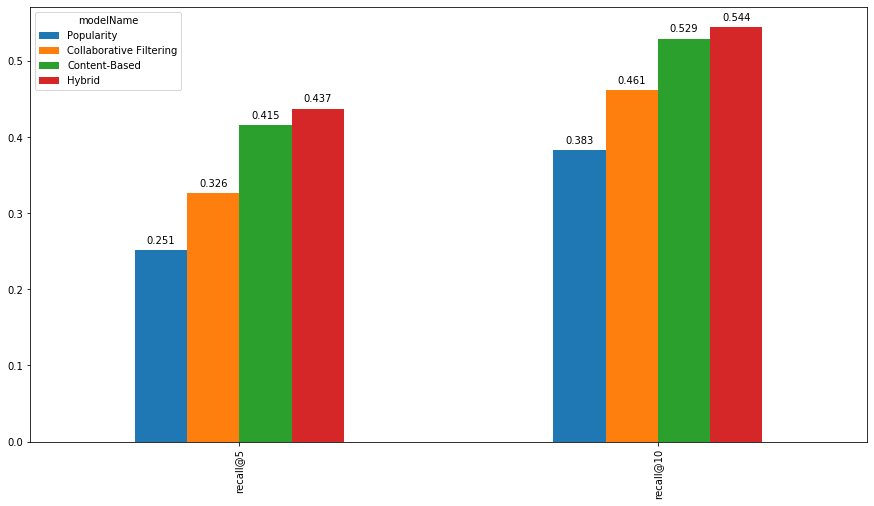

In [91]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0,10), textcoords='offset points')

## 9) Hybrid 모델을 테스트셋에 적용하기

In [94]:
def inspect_interactions(person_id, test_set = True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    
    return interactions_df.loc[person_id].merge(articles_df, how = 'left',
                                               left_on = 'contentId',
                                               right_on = 'contentId').sort_values('eventStrength', ascending=False)\
                                                [['eventStrength', 'contentId', 'title','url', 'lang']]

- 아래는 한 머신러닝에 관심있는 사용자가 실제 interact했던 뉴스 기사들이다.

In [95]:
inspect_interactions(-1479311724257856983, test_set=False).head(5)

,eventStrength,contentId,title,url,lang
20,4.285402,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
111,4.044394,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
105,3.906891,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
53,3.700440,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
46,3.700440,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en


- 이 사용자에게 Hybrid 모델을 사용한다면 어떤 아이템을 추천할까?

In [97]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=10, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,0.631084,-7126520323752764957,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
1,0.579797,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
2,0.483007,-9033211547111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en
3,0.451211,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
4,0.391237,5250363310227021277,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
5,0.342229,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
6,0.332302,8847604225354271039,"How to forecast demand with Google BigQuery, p...",https://cloud.google.com/blog/big-data/2016/05...,en
7,0.322646,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
8,0.320289,201515581783532281,CrowdFlower raises $10 million from Microsoft ...,http://venturebeat.com/2016/06/07/crowdflower-...,en
9,0.311081,-9128652074338368262,Clarifying the uses of artificial intelligence...,http://techcrunch.com/2016/05/12/clarifying-th...,en


- 매우 연관성 있는 뉴스 기사들을 추천한 것을 볼 수 있다.

## 10) 결론

- 완전히 pure한 모델보다 여러 모델을 합친 Hybrid 모델이 더 좋은 성능을 낸다는 것을 볼 수 있었다.

- 개선점:
    - 이 노트북에서는 시간을 배제시켰는데 이를 포함시킨다면 더 좋은 성능을 나타낼 것 같다.